# Optimize the types and densities of reidential towers to meet as much demand as possible with the right types of housing

In [1]:
import geopandas as gpd
import json
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
from shapely.affinity import translate
from shapely import wkt

In [3]:
import sys
sys.path.append('../../')

In [4]:
import proximity

In [5]:
def polygon_to_z_polygon(wkt):
    if 'POLYGON Z' in wkt:
        return wkt
    else:
        z_wkt=wkt.replace('POLYGON', 'POLYGON Z'
                              ).replace('),', '#').replace(  # temporarily so we can address the other commas
            ',', ' 0.0,').replace('))', ' 0.0))').replace('#', ' 0),')
        return z_wkt

def polygons_to_z_polygons(polys):
    polys_wkt=polys.geometry.to_wkt()
    z_wkt=polys_wkt.apply(polygon_to_z_polygon)
    polys['geometry']=z_wkt.apply(wkt.loads) 
    return polys

In [6]:
def get_static_access(reachable_s_all, ind_source, all_places, target_names):
    """
    inputs:
        reachable: a S*T numeric matrix where S is the number of demand sources and 
            T is the number of supply places
        ind_source: a boolean vector indicating whether each place in all_places is a source
        all_places: a GeoDataFrame including both the source and target places and a column
            for each name in target_names indicating the capacity of supply of that target 
    outputs:
        an array of numbers bounded 0-1 with a row for every source place and a column for every target type
    """
    feed_in=np.dot(reachable_s_all.T, all_places.loc[ind_source, [
        t.replace('resi', 'work') for t in target_names]].fillna(0))
    norm_capacities=(all_places[target_names].fillna(0)/feed_in
                    ).replace([np.inf, -np.inf], 0).fillna(0)
    norm_access=np.dot(reachable_s_all, norm_capacities)
#     for i_t, t in enumerate(target_names):
#         all_places.loc[ind_source, t+'_norm_access']=norm_access[:, i_t]
    return norm_access

In [7]:
def create_residential_floor_optimizer(reachable, FLOOR_LIMIT, all_places, resi_target_names,
                                resi_area_pp, unit_size_target, ind_target, ind_source):
    all_sources=all_places.loc[ind_source].copy()
    all_sources['ind_source_in_impact_area']=True
    resi_demand_mat=np.array(
        all_sources[[t.replace('resi', 'work') for t in resi_target_names]].fillna(0))

    floor_limit_candidate_spaces=[FLOOR_LIMIT]*ind_target.sum()
    
    reachable_s_all = reachable[ind_source, :]
    norm_access=get_static_access(reachable_s_all, ind_source, all_places, resi_target_names)
    
#     target_unit_capacities=np.repeat(
#             [resi_unit_capacities[target] for target in resi_target_names], ind_target.sum()) 

    target_unit_capacities=np.concatenate(
        [all_places.loc[ind_target,'capacity_for_{}'.format(t)
                       ] for t in resi_target_names]).astype(int)

    reachable_s_t=reachable_s_all[:, ind_target]   
    invA = np.dot(reachable_s_t.T,resi_demand_mat)
    inv_invA=1/invA
    
    residential_floor_optimizer=proximity.Proximizer(
        reachable_s_t, resi_demand_mat, all_sources['ind_source_in_impact_area'],
        target_unit_capacities,resi_target_names, floor_limit_candidate_spaces, 
        unit_size_target, norm_access, True,
        TARGET_WEIGHTS, MIN_CAPACITY_RATIO)    
    return residential_floor_optimizer

In [8]:
def get_resi_design(reachable, FLOOR_LIMIT, all_places, resi_target_names,
                    resi_area_pp, unit_size_target):
    ind_source=all_places['emp_total']>0
    ind_target=all_places['resi_candidate']==True
    for t in resi_area_pp:
        all_places.loc[ind_target, 'capacity_for_{}'.format(t)
                  ]=(all_places.loc[ind_target, 'area']/resi_area_pp[t]).astype(int)
    
    residential_floor_optimizer=create_residential_floor_optimizer(
        reachable, FLOOR_LIMIT, all_places, resi_target_names,
        resi_area_pp, unit_size_target, ind_target, ind_source)
    result=residential_floor_optimizer.solve()
    x_final=result.x
    total_access, target_dummys, norm_capacities, norm_access=(
        residential_floor_optimizer.split_design_vector(x_final))
    norm_access_df=pd.DataFrame(
        residential_floor_optimizer.split_by_target(resi_target_names, norm_access, 
                                           residential_floor_optimizer.n_source))
    target_dummys_final_df=pd.DataFrame(
        residential_floor_optimizer.split_by_target(resi_target_names, target_dummys, 
                                           residential_floor_optimizer.n_design))
    # for col in norm_access_df.columns:
    #     all_places.loc[ind_source, col+'_norm_access']=list(norm_access_df[col])
    for col in target_dummys_final_df.columns:
        all_places.loc[ind_target, col+'_floors']=list(
            target_dummys_final_df[col].fillna(0))
    output_resi_gdf=get_floor_geom(all_places.loc[all_places['resi_candidate']==True], 
                                   resi_target_names, z_per_floor=3)
    for col in norm_access_df:
        all_places.loc[ind_source, col+'_norm_access']=list(norm_access_df[col])
    norm_access_gdf=all_places.loc[
        ind_source, ['geometry']+[col for col in all_places.columns if 'norm_access' in col]]
    return norm_access_gdf, output_resi_gdf

In [9]:
def get_floor_geom(places_base, target_names, z_per_floor):
    """
    inputs: 
        places_base: a GeoDataFrame with of ZPolygons with one row per base geometry and 
            columns '{}_floors'.format(t)' for each target place t
        target_names: an ordered list of target places
        z_per_floor: integer in meters
    outputs:
        a GeoDataFrame with one row for every floor in each building
    """
    output_resi=[]
    for ind, row in places_base.iterrows():
        z_offset=0
        for t in target_names:
            n_floors=round(row['{}_floors'.format(t)])
            capacity=row['capacity_for_{}'.format(t)]
            for f in range(n_floors):
                z_offset+=z_per_floor
                output_resi.append(
                    {'geometry': translate(
                        geom=row.geometry, 
                        xoff=0.0, yoff=0.0, zoff=z_offset),
                     'capacity': capacity,
                     'floor_num': f,
                    'layer': t})
    output_resi_gdf=gpd.GeoDataFrame(
        output_resi, geometry='geometry', crs='epsg:4326') 
    return output_resi_gdf

# Load all geometry data

In [11]:
blds=gpd.read_file('all_spaces2.geojson')
blds['z']=0 # for the euclidean dist mat

Only keep buildings with some residents and/or employees

In [12]:
blds=blds.loc[blds[['res_total', 'emp_total']].sum(axis=1)>0]

In [13]:
# subset of close buildings
# kendall=gpd.read_file('cambridge_data/rough_kendall.geojson')
# blds['ind']=blds.index.copy()
# bld_ids=gpd.overlay(kendall, blds, 'intersection')['ind'].unique()
# blds=blds.loc[bld_ids]

In [14]:
len(blds)

273

In [15]:
blds.to_file('context_blds.geojson')

## New Buildings on Volpe site

In [17]:
volpe=gpd.read_file('footprints_wgs.geojson')

In [18]:
volpe['Layer'].unique()

array(['Residential', 'Parks', 'Offices', 'Amenities'], dtype=object)

In [19]:
volpe['resi_candidate']=volpe['Layer']=='Residential'
volpe['amen_candidate']=volpe['Layer']=='Amenities'
volpe['z']=[g.exterior.coords[0][2] for g in volpe.geometry]

#### The office space is pre-determined by the design brief

In [20]:
SQMPP_OFFICE=20
FLOORS_OFFICE=10

In [21]:
volpe.loc[volpe['Layer']=='Offices', 'floors']=FLOORS_OFFICE

In [22]:
is_office=volpe['Layer']=='Offices'
volpe['work_income_high']=0
volpe['work_income_mid']=0
volpe['work_income_low']=0
volpe.loc[is_office, 'work_income_mid']=(
    volpe.loc[is_office, 'area']*
    volpe.loc[is_office, 'floors']*(1/SQMPP_OFFICE))

In [23]:
volpe['emp_total']=volpe[
    ['work_income_low', 'work_income_mid','work_income_high']].sum(axis=1)
volpe['emp_total'].sum()

2151.490197292964

# Vacant Parcels

In [25]:
vacant_residential=gpd.read_file(
    'vacant_residential.geojson')
# vacant_commercial=gpd.read_file(
#     'vacant_commercial.geojson')

In [26]:
vacant_residential['resi_candidate']=True
# vacant_commercial['amen_candidate']=True
vacant_residential['z']=0
# vacant_commercial['z']=0

In [27]:
# vacant_commercial=vacant_commercial.explode(index_parts=False).reset_index()

In [28]:
vacant_residential=polygons_to_z_polygons(vacant_residential)
# vacant_commercial=polygons_to_z_polygons(vacant_commercial)

# Distance Matrix and friction function

### TODO: make a proper 3D distance matrix

In [29]:
all_places=pd.concat([blds, volpe, 
                      vacant_residential, 
#                       vacant_commercial
                     ])
# all_places=volpe

In [30]:
all_places.explore(column='resi_candidate', 
                   tooltip='work_income_high')

In [31]:
centroids=all_places.to_crs(proximity.get_crs(volpe)).geometry.centroid
all_places['x']=[c.x for c in centroids]
all_places['y']=[c.y for c in centroids]

In [32]:
dist_mat=scipy.spatial.distance_matrix(
    all_places[['x', 'y', 'z']],
    all_places[['x', 'y', 'z']])

In [33]:
dist_mat.shape

(414, 414)

Text(0, 0.5, 'Reachability')

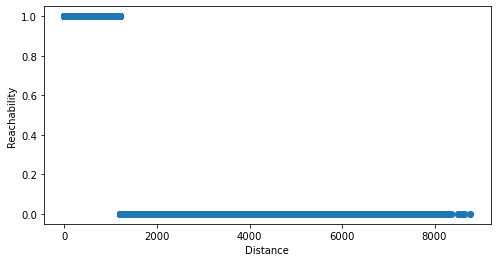

In [34]:
MAX_DIST=1200
reachable = (dist_mat<MAX_DIST).astype(int)
fig, ax = plt.subplots(figsize=(8,4), sharex=True)
ax.scatter(dist_mat.flatten(), reachable.flatten())

ax.set_xlabel('Distance')
ax.set_ylabel('Reachability')

<AxesSubplot:>

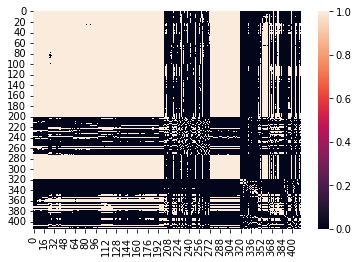

In [35]:
import seaborn as sns
sns.heatmap(reachable)

# Inputs needed for Proximisation
- reachable_s_t <br>
n_all_sources (including outside impact area?) * n_potential_target_locations
- demand_mat <br>
ARRAY: n_sources * n_targets
- ind_source_in_impact_area <br>
binary vector, length = n_sources (????)
- target_unit_capacities <br>
capacity of one unit of the resource (population-carrying capacity). 1D vector, length  = n_candiate_locations * n_target_types <br>
[unit capacity amenity1 repeated for every candidate location: ...]
- targets <br>
list of names
- size_spaces <br>
num units (can be measured in sqm, floors etc.) available for targets in every candidate location
- unit_sizes <br>
the size of one unit (can be measured in sqm, floors etc.)
list: [sqmp1000_by_amenity[a]/Npoi_p1000_by_amenity[a] for a in amenity_list]
- norm_access_static <br>
DF, row for every source, na->0
- integer_amenities <br>

In [36]:
resi_target_names=['resi_income_low', 'resi_income_mid', 'resi_income_high']

resi_area_pp={'resi_income_high': 50, 
              'resi_income_mid': 40,
              'resi_income_low': 30}
unit_size_target = [1, 1, 1]

In [37]:
# with area_ratio of 4/3 and MIN_CAPACITY_RATIO of 0.3
# to make the value of each unit equal:
# 3/4 (w-0.3) = 0.7
# 3/4w - 0.3*(3/4) = 0.7
# w = 4/3* (0.7+(0.3*(3/4)))
MIN_CAPACITY_RATIO=0.5
TARGET_WEIGHTS=[1, 1, 1]
area_ratios= [1, 4/3, 5/3]
TARGET_WEIGHTS= [ar*((1-MIN_CAPACITY_RATIO)+(MIN_CAPACITY_RATIO*(1/ar)))
                for ar in area_ratios]
TARGET_WEIGHTS

[1.0, 1.1666666666666665, 1.3333333333333335]

In [38]:
FLOOR_LIMIT=40

In [39]:
norm_access_gdf, output_resi_gdf=get_resi_design(reachable, FLOOR_LIMIT, all_places, resi_target_names,
                    resi_area_pp, unit_size_target)

/var/folders/30/clhynt5s7fx_3nyyxfl04f780000gn/T/ipykernel_35512/946824174.py:22: RuntimeWarning: divide by zero encountered in divide
  inv_invA=1/invA
/Users/ronandoorley/Documents/Media_Lab/CityScope/Proximization/examples/cambridge/../../proximity.py:122: RuntimeWarning: divide by zero encountered in divide
  inv_invA=1/invA


Calculating inverse Access
Creating inequality constraint 1
Creating inequality constraint 2
Creating inequality constraint 3
Creating equality constraints
Creating equality constraint 1
Creating equality constraint 2
Sucess: True


In [46]:
output_resi_gdf.to_file('output_resi.geojson')
norm_access_gdf.to_file('resi_norm_access.geojson')

In [47]:
output_resi_gdf.explore()